In [7]:
pip install shap

In [8]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV ,StratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTENC
from sklearn.inspection import permutation_importance
import shap
#from sklearn.compose import TransformedTargetRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier


In [9]:
def Get_Data():
  df_xray = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/xray.pkl")
  df_clinical = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/clinical.pkl")
  df_mri = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/mri.pkl")
  df_questionnaires = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/questionnaires.pkl")
  df_tomography = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/tomography.pkl")
  df_biomarkers = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/biomarkers.pkl")
  df_progression = pd.read_csv('/content/drive/MyDrive/Dissertation Final/progression.csv')
  return(df_xray,df_clinical,df_mri,df_questionnaires,df_tomography,df_biomarkers,df_progression)

In [10]:
df_xray,df_clinical,df_mri,df_questionnaires,df_tomography,df_biomarkers,df_progression = Get_Data()

In [11]:
df_xray.shape

(297, 24)

In [12]:
df_mri.shape

(297, 133)

In [13]:
(df_xray.isnull().sum().sum()/df_xray.size)*100

1.3187429854096522

In [14]:
(df_mri.isnull().sum().sum()/df_mri.size)*100

3.6556036556036555

In [15]:
df_progression

,ID,S,P
0,1,0,0
1,5,0,0
2,7,1,1
3,11,0,1
4,12,0,1
...,...,...,...
218,424,0,0
219,426,1,0
220,432,0,1
221,433,0,0


<Axes: xlabel='S', ylabel='count'>

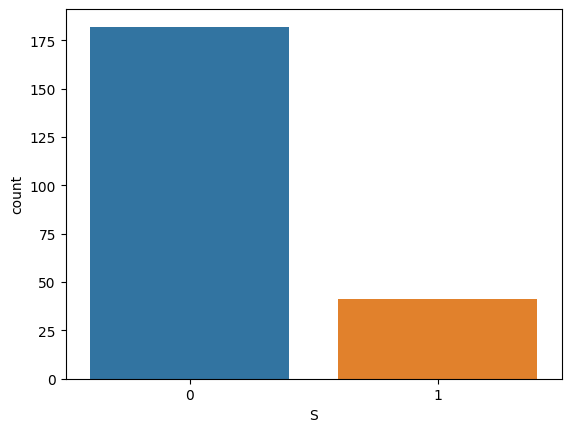

In [16]:
#Switch between 'S' and 'P' to see the class label distribution
sns.countplot(x=df_progression['S'])

In [17]:
df_progression['multiclass_labels'] = df_progression['P'] * 2 + df_progression['S']

In [18]:
df_progression

,ID,S,P,multiclass_labels
0,1,0,0,0
1,5,0,0,0
2,7,1,1,3
3,11,0,1,2
4,12,0,1,2
...,...,...,...,...
218,424,0,0,0
219,426,1,0,1
220,432,0,1,2
221,433,0,0,0


In [19]:
df_progression = df_progression.drop(['S','P'],axis =1)

In [20]:
df_progression, df_progression.shape


(      ID  multiclass_labels
 0      1                  0
 1      5                  0
 2      7                  3
 3     11                  2
 4     12                  2
 ..   ...                ...
 218  424                  0
 219  426                  1
 220  432                  2
 221  433                  0
 222  434                  3
 
 [223 rows x 2 columns],
 (223, 2))

In [21]:
df_progression['multiclass_labels'].value_counts()

0    115
2     67
1     30
3     11
Name: multiclass_labels, dtype: int64

In [22]:
def Join_DataSets(df1,df2):
  return(df1.join(df2))

In [23]:
joined_df = Join_DataSets(df_xray, df_clinical)

In [24]:
joined_df.shape

(297, 62)

In [25]:
id_sub = df_xray.index
output = {n: int(str(n)[-3:]) for n in id_sub}

In [26]:
dic_reversed = {v: k for k, v in output.items()}
df_progression['Key'] = df_progression['ID'].map(dic_reversed)
df_progression['Key'] = df_progression['Key'].replace({np.nan: 'NaN'})

In [27]:
df_progression = df_progression.drop(['ID'],axis =1)

In [28]:
merged_df = pd.merge(df_progression, joined_df , left_on='Key', right_on='Subject ID')

In [29]:
merged_df = merged_df.drop(['Key'],axis =1)

#**Exploratory Data Analysis**

In [30]:
merged_df.shape

(223, 63)

In [31]:
merged_df['multiclass_labels'].value_counts()

0    115
2     67
1     30
3     11
Name: multiclass_labels, dtype: int64

<Axes: xlabel='multiclass_labels', ylabel='count'>

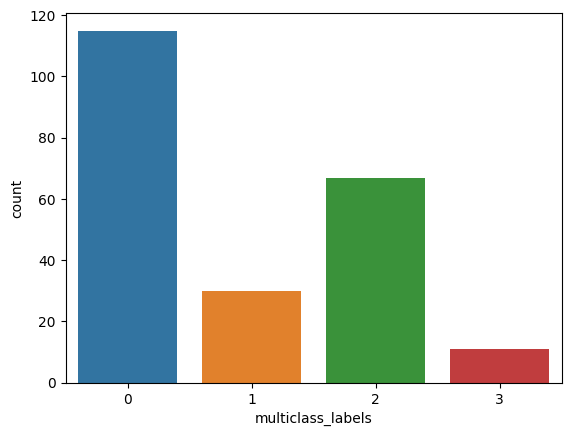

In [32]:
sns.countplot(x=merged_df['multiclass_labels'])

In [33]:
merged_df.isnull().sum()

multiclass_labels        0
Density_Mean_Femur_K     0
Density_Mean_Tibia_K     0
Femorotibial_Angle_K     0
JSW_Mean_K               0
                        ..
PE_Knee_Warmth           0
ROM_Min_Knee_Swing      10
ROM_Stance_K            10
Age                      0
Sex                      0
Length: 63, dtype: int64

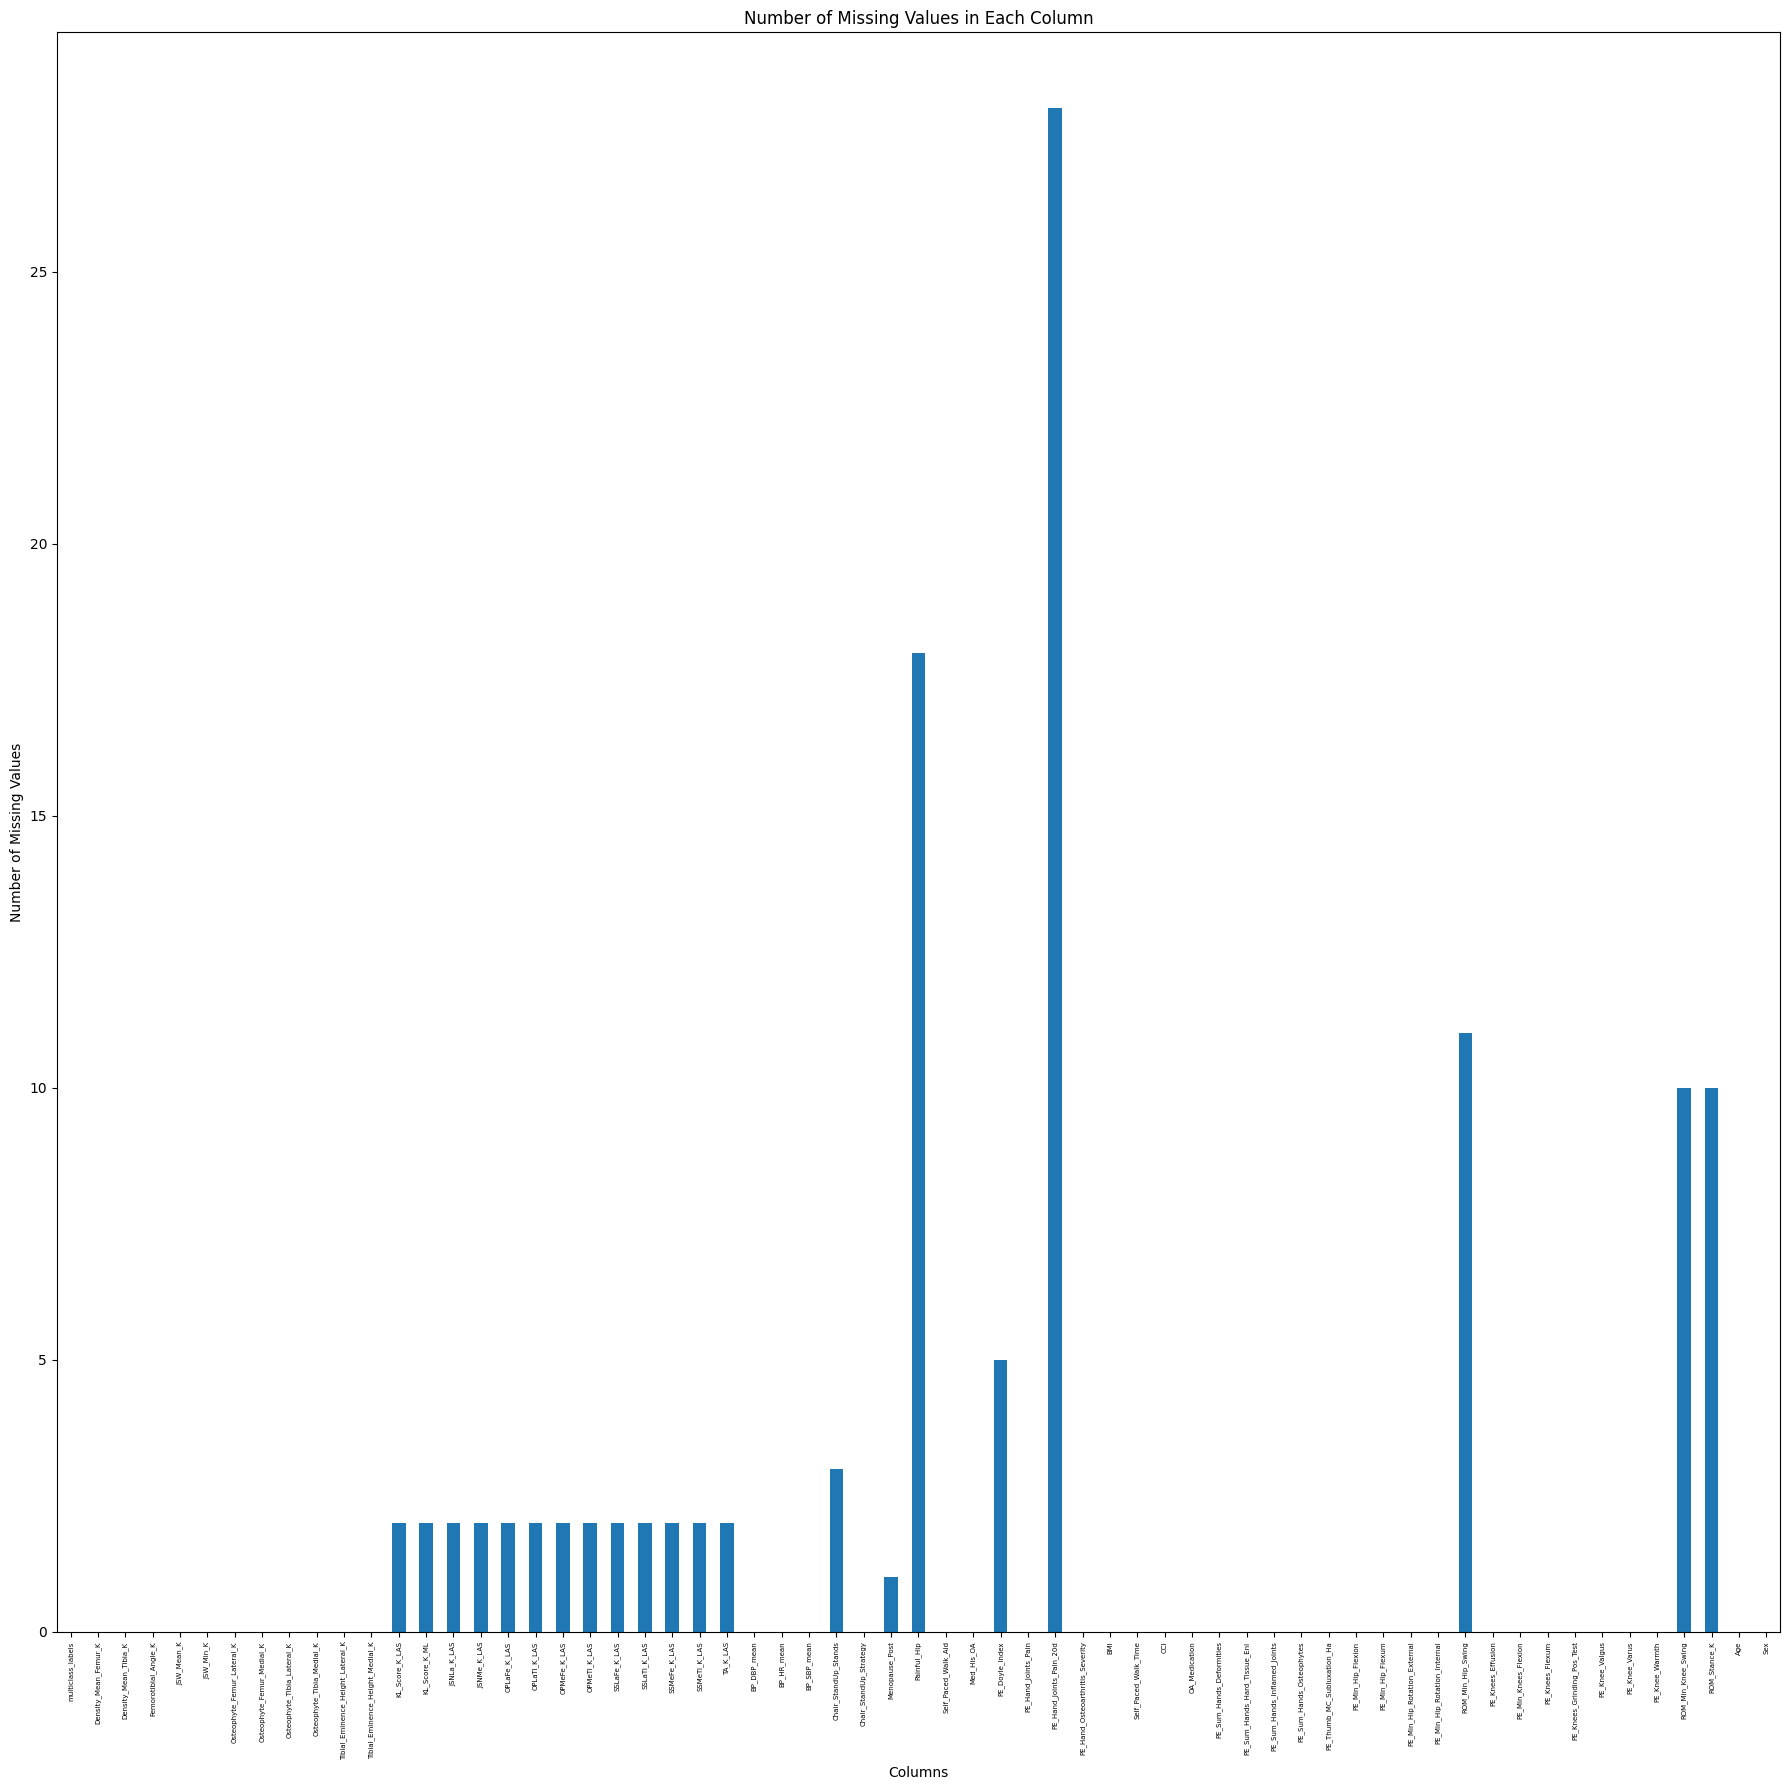

In [34]:
plt.figure(figsize=(18, 18))
merged_df.isnull().sum().plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Number of Missing Values in Each Column')
plt.xticks(rotation = 90, fontsize=5)
plt.tight_layout()
plt.show()

In [35]:
numerical_count = merged_df.select_dtypes(include=['int', 'float']).shape[1]
categorical_count = merged_df.select_dtypes(include=['object', 'category']).shape[1]

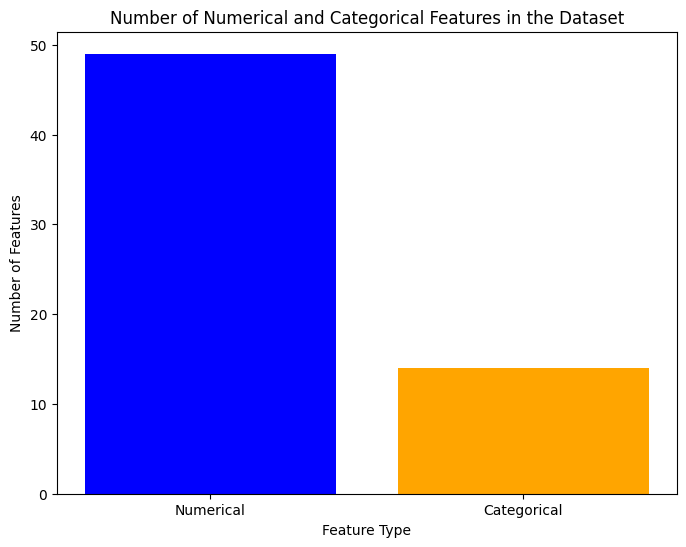

In [36]:
plt.figure(figsize=(8, 6))
plt.bar(['Numerical', 'Categorical'], [numerical_count, categorical_count], color=['blue', 'orange'])
plt.xlabel('Feature Type')
plt.ylabel('Number of Features')
plt.title('Number of Numerical and Categorical Features in the Dataset')
plt.show()

<Axes: >

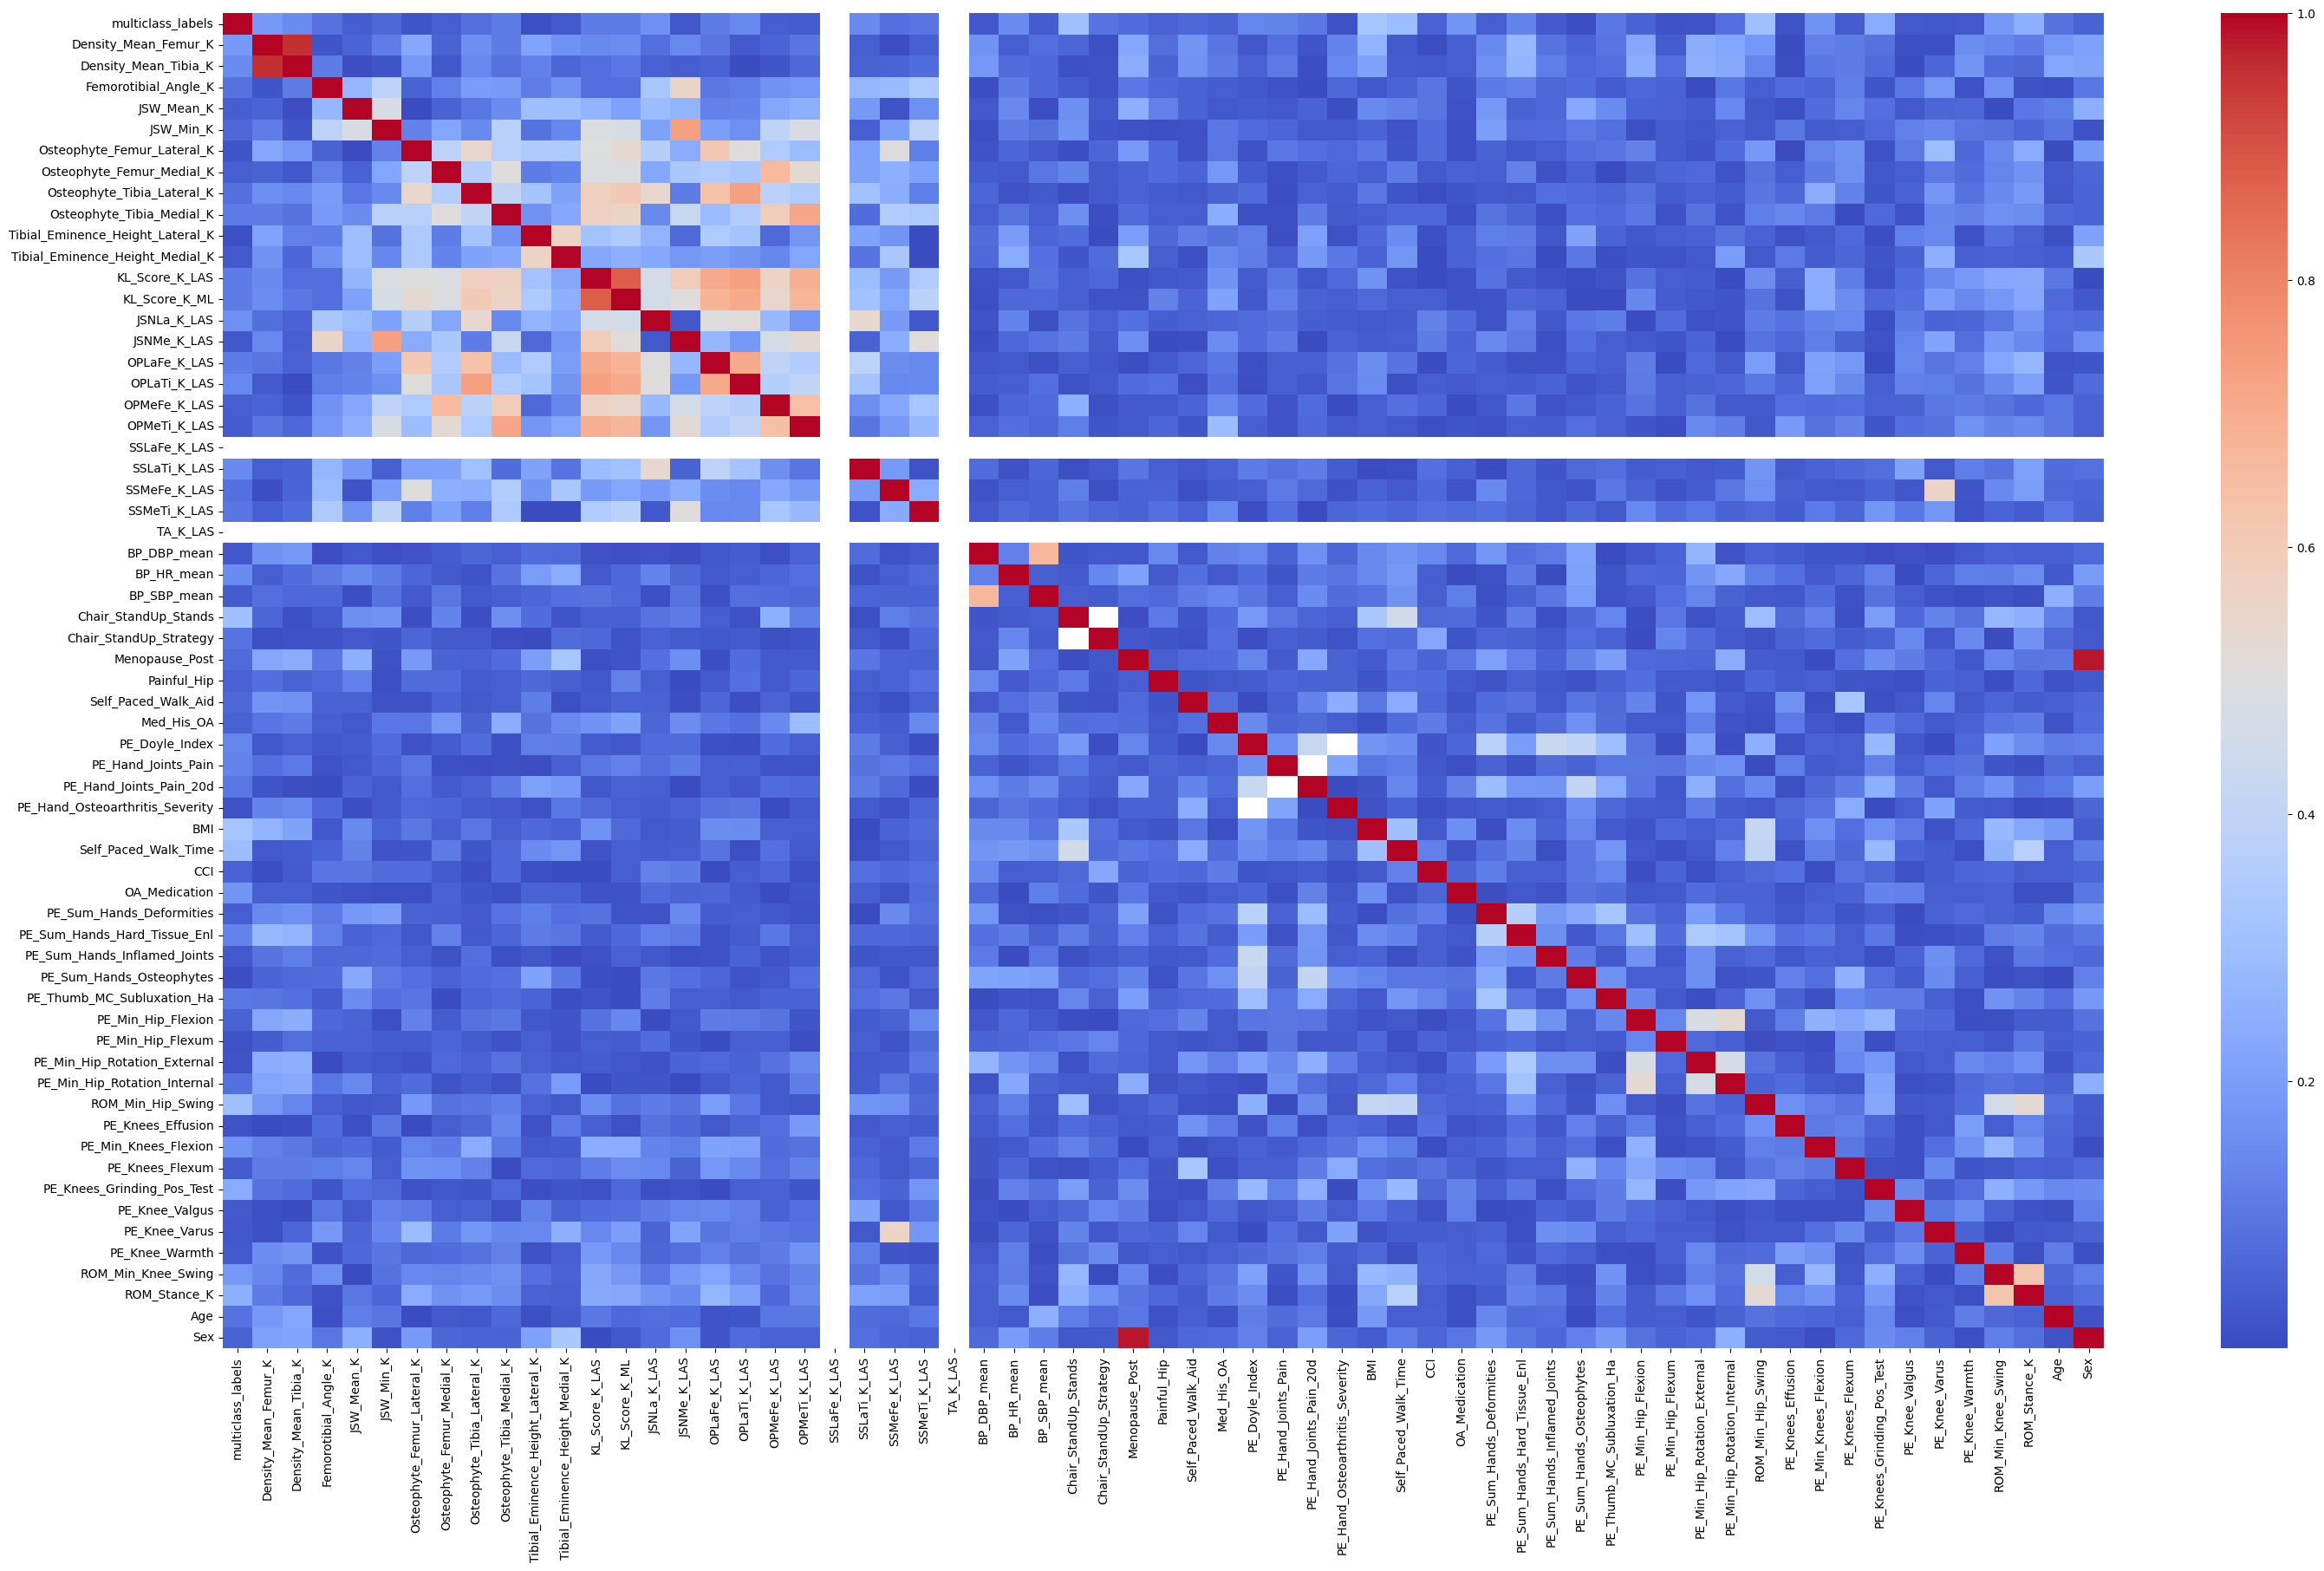

In [37]:
correlation_heatmap = merged_df.astype(float).corr().abs()
plt.figure(figsize = (35,20))
sns.heatmap(correlation_heatmap,annot=False,cmap = 'coolwarm')

In [38]:
summary_stats = merged_df.describe()
summary_stats

,multiclass_labels,Density_Mean_Femur_K,Density_Mean_Tibia_K,Femorotibial_Angle_K,JSW_Mean_K,JSW_Min_K,Osteophyte_Femur_Lateral_K,Osteophyte_Femur_Medial_K,Osteophyte_Tibia_Lateral_K,Osteophyte_Tibia_Medial_K,...,PE_Knees_Effusion,PE_Min_Knees_Flexion,PE_Knees_Flexum,PE_Knees_Grinding_Pos_Test,PE_Knee_Valgus,PE_Knee_Varus,PE_Knee_Warmth,ROM_Min_Knee_Swing,ROM_Stance_K,Age
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,...,223.0,223.0,223.0,223.0,223.0,223.0,223.0,213.000000,213.000000,223.000000
mean,0.883408,29.857848,31.646278,-3.543857,5.508341,2.570090,4.749955,3.172152,7.298161,4.685605,...,0.237668,2.686099,0.130045,0.38565,0.121076,0.053812,0.053812,16.748826,16.574648,66.372197
std,1.002179,4.801931,5.270543,2.653077,0.962744,1.222923,5.371000,6.076005,9.622534,4.673542,...,0.521621,0.502368,0.430946,0.646662,0.453867,0.245264,0.226153,4.897762,5.179733,6.943825
min,0.000000,20.100000,20.100000,-11.790000,3.110000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.300000,2.000000,44.000000
25%,0.000000,25.965000,27.805000,-5.315000,4.805000,1.875000,0.000000,0.000000,1.995000,1.560000,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,13.300000,13.600000,62.000000
50%,0.000000,29.300000,31.060000,-3.300000,5.410000,2.740000,3.810000,0.000000,4.140000,3.490000,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,17.000000,16.600000,67.000000
75%,2.000000,33.515000,35.115000,-1.845000,6.190000,3.505000,7.020000,4.835000,8.380000,6.275000,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,20.200000,20.400000,71.000000
max,3.000000,43.250000,47.550000,3.210000,8.140000,5.390000,34.710000,45.400000,72.960000,26.940000,...,2.0,3.0,2.0,2.0,2.0,2.0,1.0,29.100000,33.300000,82.000000


#**Pre-processing**

In [39]:
merged_df.dropna(axis=1, thresh=0.6 * merged_df.shape[0], inplace=True)
merged_df = merged_df.loc[:, merged_df.apply(lambda column: column.nunique() > 1)]

In [40]:
merged_df.shape

(223, 61)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(merged_df.drop(columns=['multiclass_labels']),merged_df['multiclass_labels'],test_size = 0.2)

In [42]:
X_train_column_names = X_train.columns.tolist()
X_train_numerical_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
X_train_categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()


In [43]:
X_train_categorical_feature_indices = [X_train.columns.get_loc(col) for col in X_train_categorical_features]

In [44]:
X_train.isnull().sum().sum(), X_test.isnull().sum().sum()

(78, 30)

In [45]:
numeric_transformer = Pipeline(
    steps=[("imputer", KNNImputer()), ("scaler", MinMaxScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_train_numerical_features),
        ("cat", categorical_transformer, X_train_categorical_features),
    ]
)

In [46]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [47]:
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns = X_train_column_names )
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns = X_train_column_names)

In [48]:
X_train_preprocessed.isnull().sum().sum(), X_test_preprocessed.isnull().sum().sum()

(0, 0)

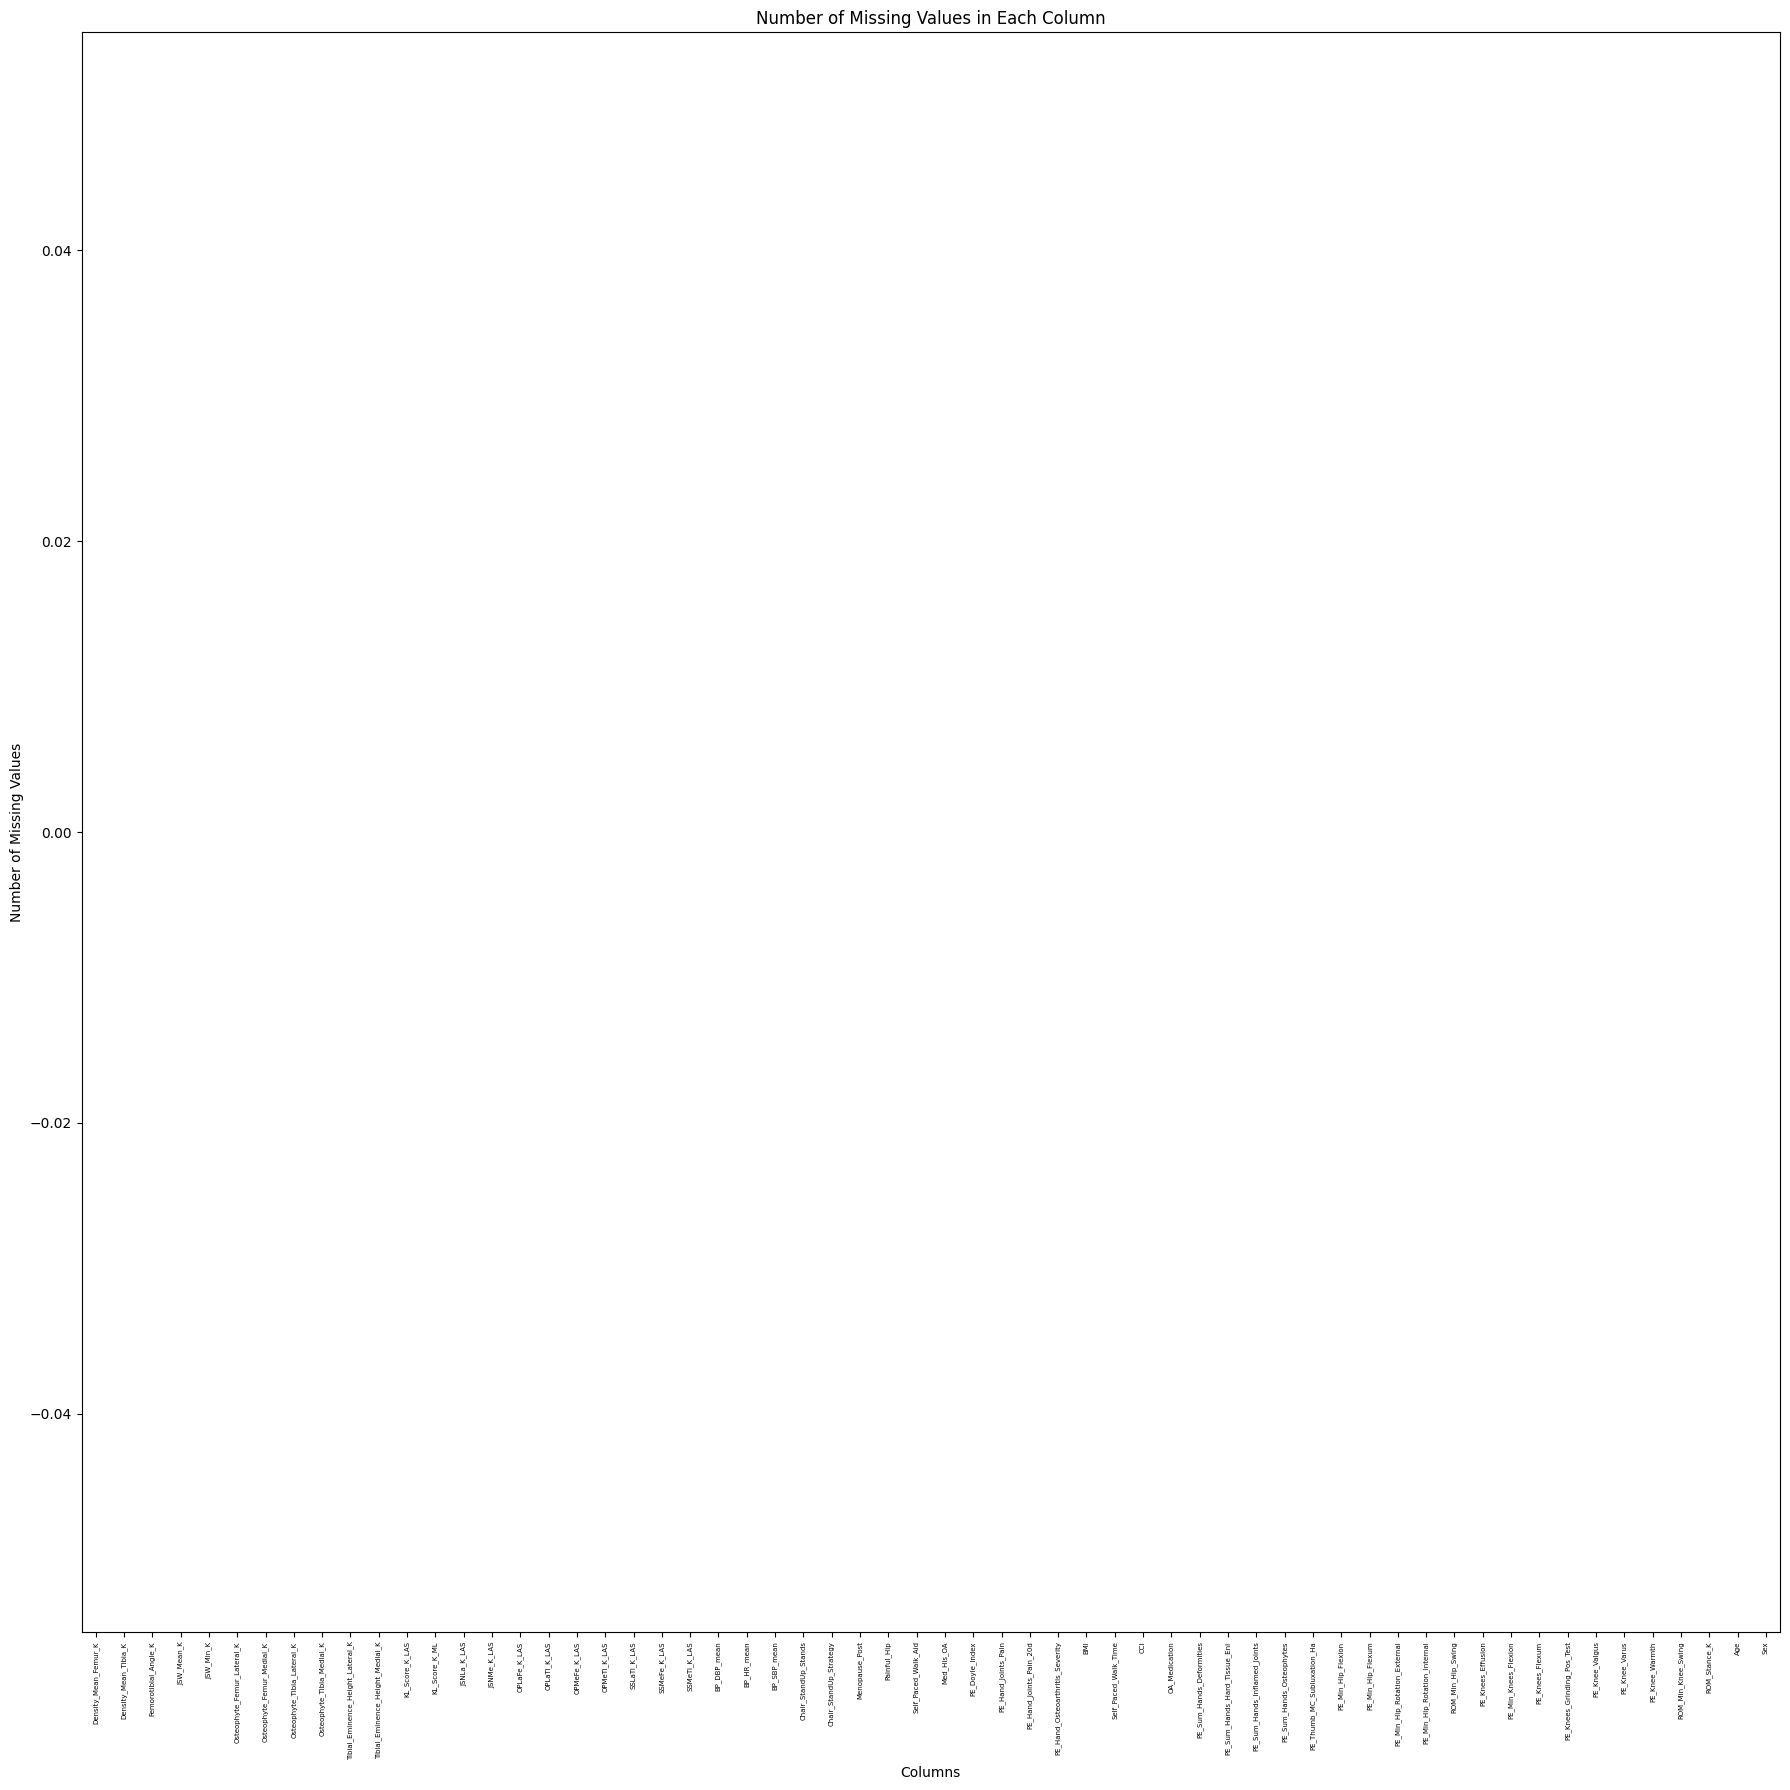

In [49]:
plt.figure(figsize=(18, 18))
X_test_preprocessed.isnull().sum().plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Number of Missing Values in Each Column')
plt.xticks(rotation = 90, fontsize=5)
plt.tight_layout()
plt.show()

#**Oversampling**

In [50]:
y_train.value_counts()

0    94
2    51
1    24
3     9
Name: multiclass_labels, dtype: int64

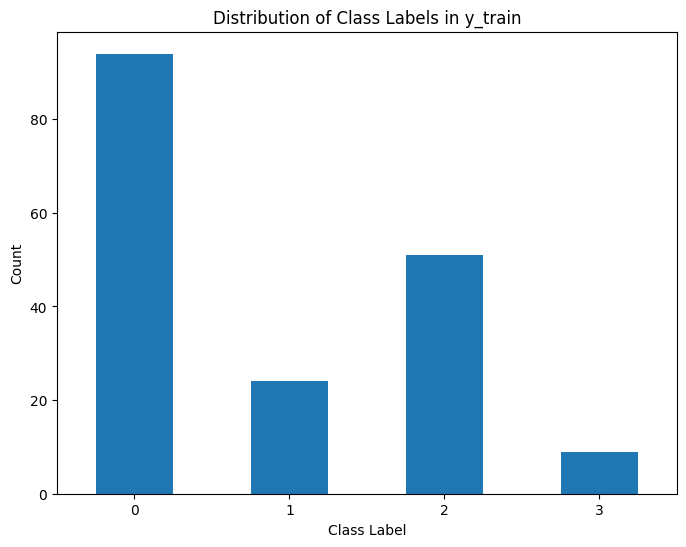

In [51]:
plt.figure(figsize=(8, 6))
y_train.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Class Labels in y_train')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [52]:
oversample = SMOTENC(categorical_features=X_train_categorical_feature_indices, random_state=42)
X_train_preprocessed_balanced, y_train_balanced = oversample.fit_resample(X_train_preprocessed, y_train)


In [53]:
y_train_balanced.value_counts()

0    94
2    94
1    94
3    94
Name: multiclass_labels, dtype: int64

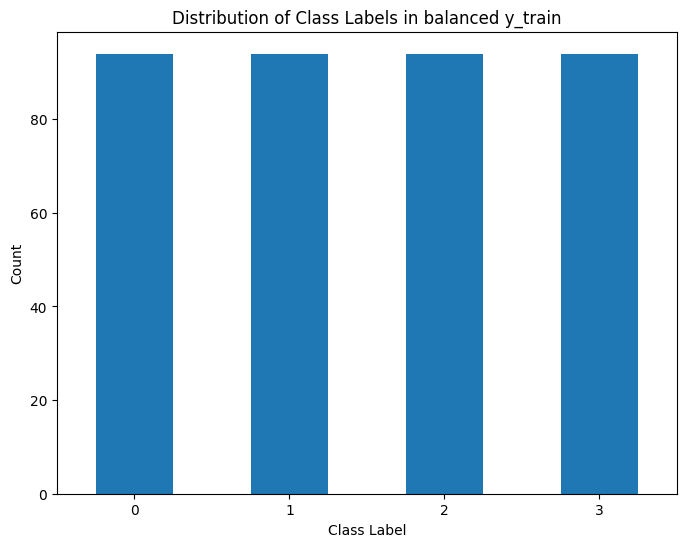

In [54]:
plt.figure(figsize=(8, 6))
y_train_balanced.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Class Labels in balanced y_train')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#**One hot encoding**

In [55]:
def perform_one_hot_encoding(data1,data2, categorical_columns):
  encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
  encoded_columns1 = encoder.fit_transform(data1[categorical_columns])
  encoded_columns2 = encoder.transform(data2[categorical_columns])
  encoded_data1 = pd.DataFrame(encoded_columns1, columns=encoder.get_feature_names_out(categorical_columns))
  encoded_data2 = pd.DataFrame(encoded_columns2, columns=encoder.get_feature_names_out(categorical_columns))
  print(encoded_data1.shape)
  data1 = data1.drop(columns=categorical_columns)
  data2 = data2.drop(columns=categorical_columns)
  data1 = pd.concat([data1, encoded_data1], axis=1)
  data2 = pd.concat([data2, encoded_data2], axis=1)
  return data1,data2

In [56]:
X_train_preprocessed_balanced_encoded, X_test_preprocessed_encoded = perform_one_hot_encoding(X_train_preprocessed_balanced,X_test_preprocessed, X_train_categorical_features)


(376, 322)


In [57]:
X_train_preprocessed_balanced_encoded.shape, X_test_preprocessed_encoded.shape

((376, 370), (45, 370))

# **Feature selection using correlation**

In [58]:
def highly_correlated(df):
  correlations = df.astype(float).corr().abs()
  mask = np.triu(np.ones(correlations.shape), k=1).astype(bool)
  correlations.where(mask, inplace=True)
  print("Correlation Matrix:")
  print(correlations)
  columns_to_drop = [i for i in correlations if any(abs(correlations[i]) >= 0.7)]
  df.drop(columns=columns_to_drop, inplace=True)
  plt.figure(figsize = (35,20))
  sns.heatmap(correlations,annot=False,cmap = 'coolwarm')
  return(df)

Correlation Matrix:
                      Density_Mean_Femur_K  Density_Mean_Tibia_K  \
Density_Mean_Femur_K                   NaN               0.95731   
Density_Mean_Tibia_K                   NaN                   NaN   
Femorotibial_Angle_K                   NaN                   NaN   
JSW_Mean_K                             NaN                   NaN   
JSW_Min_K                              NaN                   NaN   
...                                    ...                   ...   
OA_Medication_0.0                      NaN                   NaN   
OA_Medication_0.5                      NaN                   NaN   
OA_Medication_1.0                      NaN                   NaN   
Sex_1                                  NaN                   NaN   
Sex_2                                  NaN                   NaN   

                      Femorotibial_Angle_K  JSW_Mean_K  JSW_Min_K  \
Density_Mean_Femur_K              0.003137    0.066877   0.056148   
Density_Mean_Tibia_K     

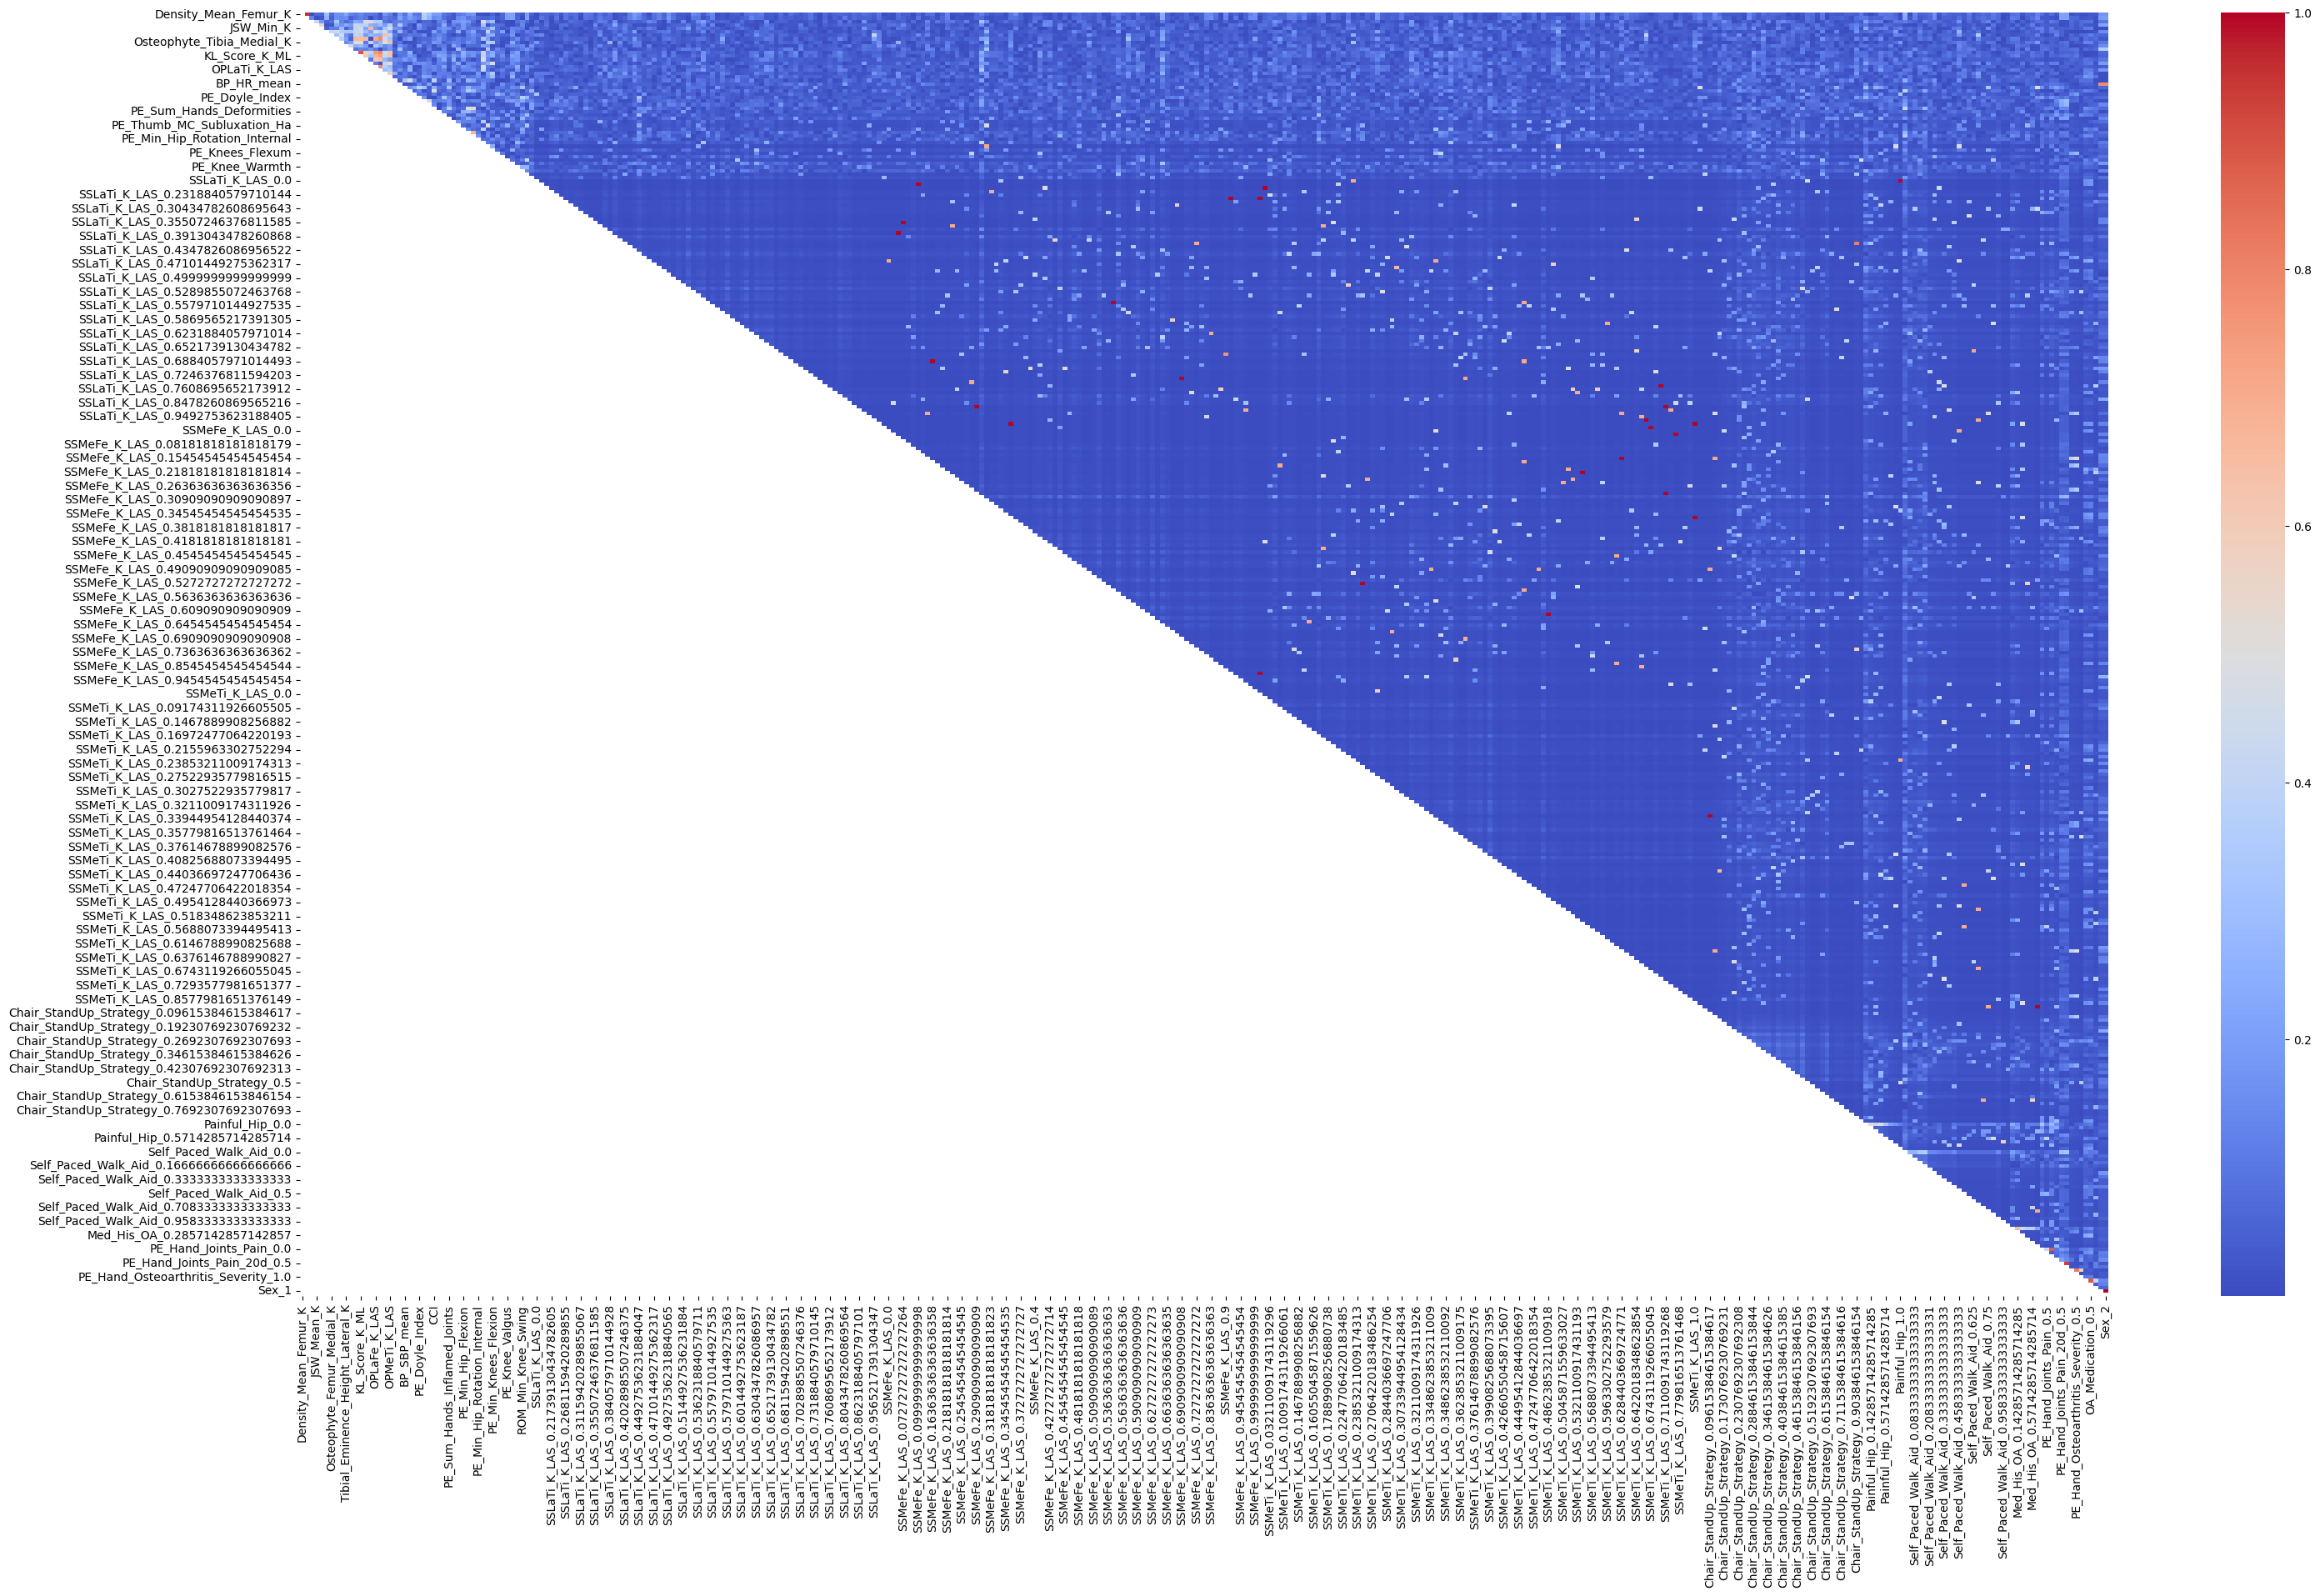

In [59]:
X_train_preprocessed_balanced_encoded_corr = highly_correlated(X_train_preprocessed_balanced_encoded)

<Axes: >

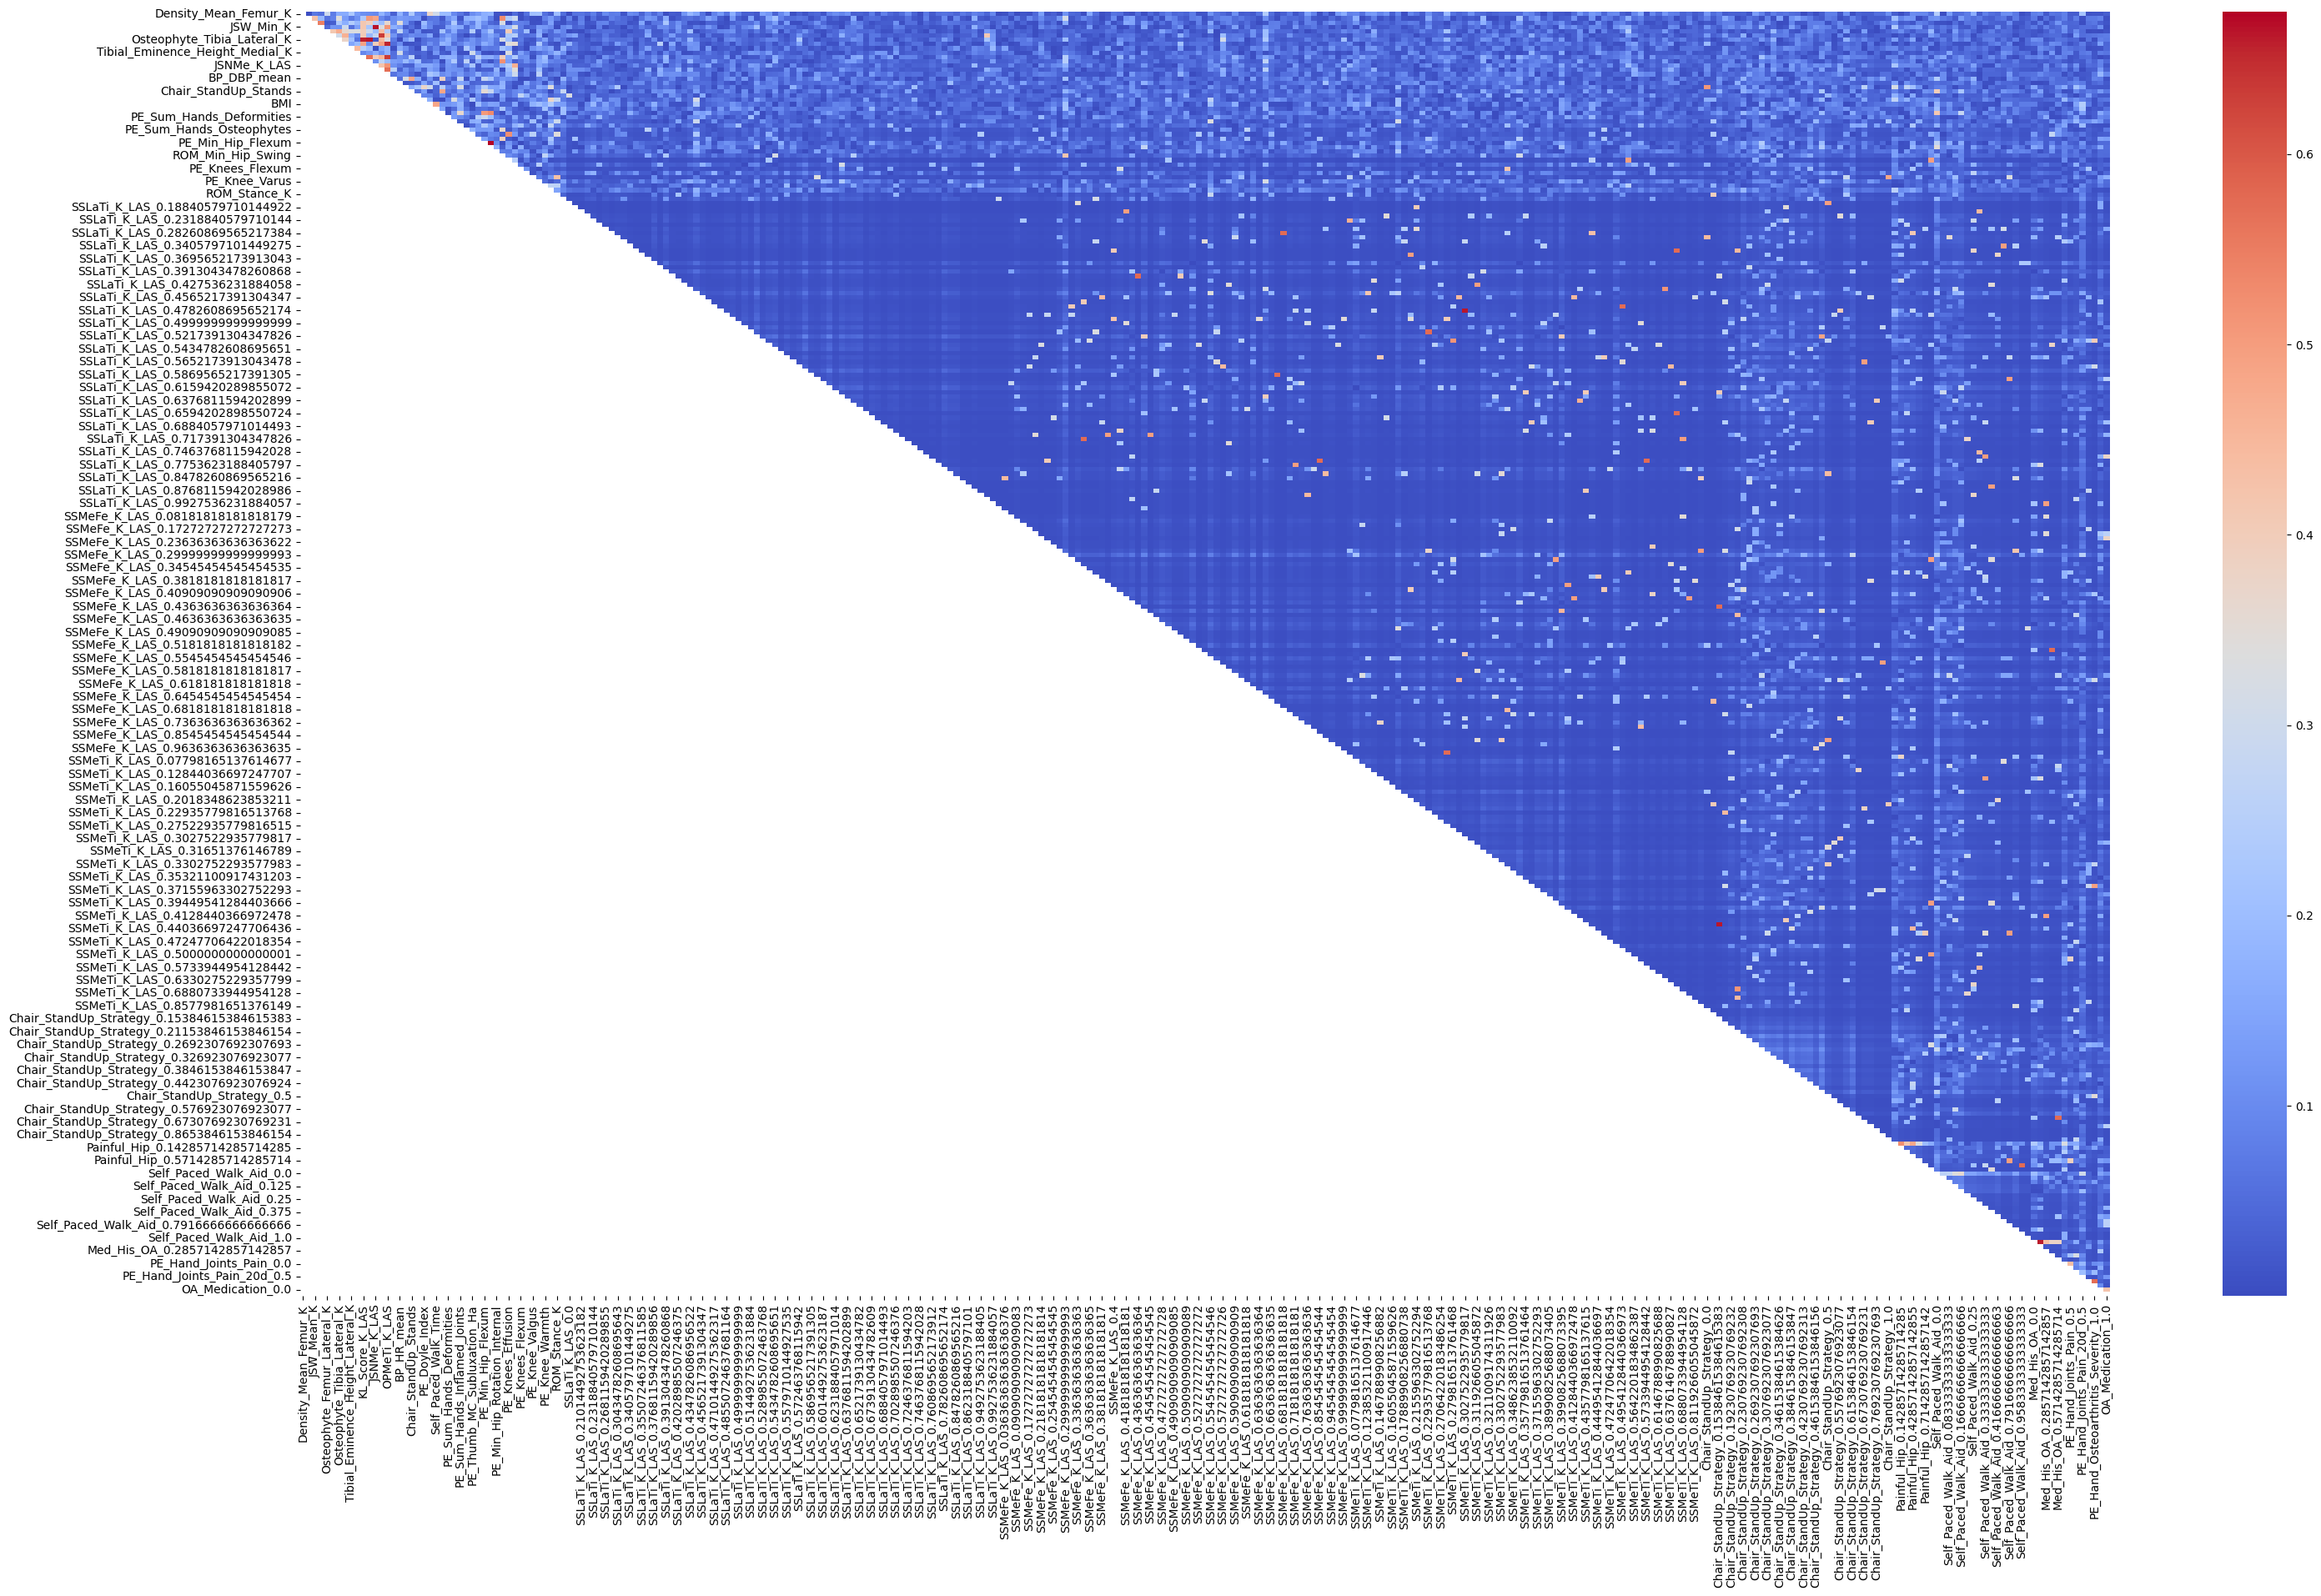

In [60]:
correlation_new = X_train_preprocessed_balanced_encoded_corr.astype(float).corr().abs()
mask = np.triu(np.ones(correlation_new.shape), k=1).astype(bool)
correlation_new.where(mask, inplace=True)
plt.figure(figsize = (35,20))
sns.heatmap(correlation_new,annot=False,cmap = 'coolwarm')

In [61]:
X_train_preprocessed_balanced_encoded_corr.shape

(376, 299)

In [62]:
column_names_final  = X_train_preprocessed_balanced_encoded_corr.columns.tolist()

In [63]:
X_test_preprocessed_encoded_corr = X_test_preprocessed_encoded[column_names_final]

In [64]:
X_train_preprocessed_balanced_encoded_corr.shape,X_test_preprocessed_encoded_corr.shape,y_train_balanced.shape,y_test.shape

((376, 299), (45, 299), (376,), (45,))

**Machine Learning Pipeline**

In [65]:
def knnModel(X_train, X_test, y_train, y_test):
  knn_clf = KNeighborsClassifier()
  inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
  knn_param_grid = {'n_neighbors': [3, 5, 7,11,15,20]}
  knn_search = HalvingGridSearchCV(knn_clf, knn_param_grid, cv=inner_cv)
  knn_search.fit(X_train, y_train)
  knn_pred = knn_search.predict(X_test)
  knn_accuracy = accuracy_score(y_test, knn_pred)
  knn_f1_macro = f1_score(y_test, knn_pred, average='macro')
  selected_features_list = []

  perm_importance = permutation_importance(knn_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
  feature_importances = perm_importance.importances_mean
  num_features_to_select = 5
  important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
  selected_features = X_train.columns[important_feature_indices]
  selected_features_list.append(selected_features)
  X_train_selected = X_train[selected_features]
  X_test_selected = X_test[selected_features]
  clf_selected = knn_search.best_estimator_
  clf_selected.fit(X_train_selected, y_train)
  results_df = pd.DataFrame({
        'Classifier': "KNN",
        'Accuracy': knn_accuracy,
        'F1 Score Macro': knn_f1_macro,
        'Best Params': knn_search.best_params_
  })
  explainer_knn = shap.KernelExplainer(clf_selected.predict, X_train_selected)
  shap_values_knn = explainer_knn.shap_values(X_test_selected)
  shap.summary_plot(shap_values_knn, X_test_selected, feature_names=X_test_selected.columns)
  return results_df,selected_features_list

  0%|          | 0/45 [00:00<?, ?it/s]

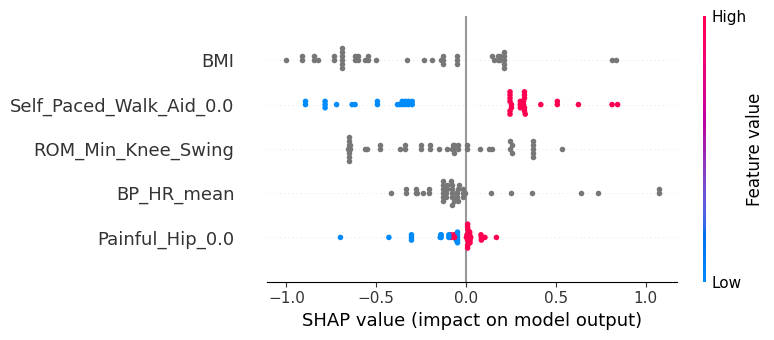

(            Classifier  Accuracy  Weighted F1 Score  Best Params
 n_neighbors        KNN  0.466667           0.357971            3,
 [Index(['Painful_Hip_0.0', 'BMI', 'BP_HR_mean', 'Self_Paced_Walk_Aid_0.0',
         'ROM_Min_Knee_Swing'],
        dtype='object')])

In [66]:
knnModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)

In [67]:
def randomForestModel(X_train, X_test, y_train, y_test):
    rf_clf = RandomForestClassifier()
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    rf_param_grid = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [None, 10, 20, 30, 40, 50]}
    rf_search = HalvingGridSearchCV(rf_clf, rf_param_grid, cv=inner_cv)
    rf_search.fit(X_train, y_train)
    rf_pred = rf_search.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_f1_macro = f1_score(y_test, rf_pred, average='macro')

    selected_features_list = []

    # Permutation importance for feature selection
    perm_importance = permutation_importance(rf_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
    feature_importances = perm_importance.importances_mean
    num_features_to_select = 5
    important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
    selected_features = X_train.columns[important_feature_indices]
    selected_features_list.append(selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    clf_selected = rf_search.best_estimator_
    clf_selected.fit(X_train_selected, y_train)

    results_df = pd.DataFrame({
        'Classifier': "Random Forest",
        'Accuracy': rf_accuracy,
        'F1 Score Macro': rf_f1_macro,
        'Best Params': [rf_search.best_params_]
    })

    explainer_rf = shap.TreeExplainer(clf_selected)
    shap_values_rf = explainer_rf.shap_values(X_test_selected)
    shap.summary_plot(shap_values_rf[0], X_test_selected, feature_names=X_test_selected.columns)

    return results_df,selected_features_list




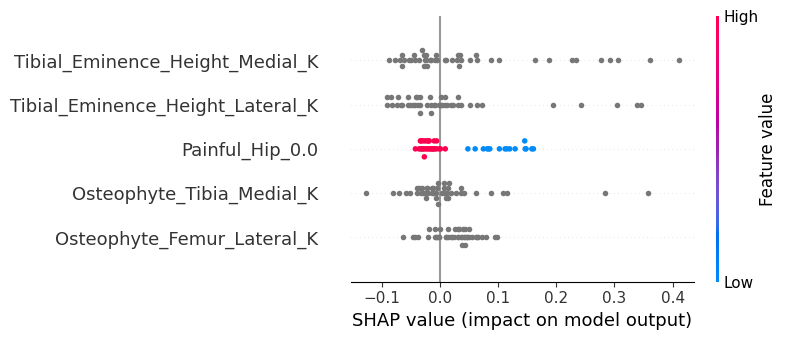

(      Classifier  Accuracy  F1 Score Macro  \
0  Random Forest  0.444444        0.238714   

                              Best Params  
0  {'max_depth': 20, 'n_estimators': 500}  , [Index(['Osteophyte_Tibia_Medial_K', 'Osteophyte_Femur_Lateral_K',
       'Tibial_Eminence_Height_Medial_K', 'Painful_Hip_0.0',
       'Tibial_Eminence_Height_Lateral_K'],
      dtype='object')])


In [68]:
results = randomForestModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)
print(results)

In [69]:
def annModel(X_train, X_test, y_train, y_test):
    ann_clf = MLPClassifier(max_iter=1000)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    ann_param_grid = {'hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30)]}
    ann_search = HalvingGridSearchCV(ann_clf, ann_param_grid, cv=inner_cv)
    ann_search.fit(X_train, y_train)
    ann_pred = ann_search.predict(X_test)
    ann_accuracy = accuracy_score(y_test, ann_pred)
    ann_f1_macro = f1_score(y_test, ann_pred, average='macro')

    selected_features_list = []

    # Permutation importance for feature selection
    perm_importance = permutation_importance(ann_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
    feature_importances = perm_importance.importances_mean
    num_features_to_select = 5
    important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
    selected_features = X_train.columns[important_feature_indices]
    selected_features_list.append(selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    clf_selected = ann_search.best_estimator_
    clf_selected.fit(X_train_selected, y_train)

    results_df = pd.DataFrame({
        'Classifier': "Artificial Neural Network",
        'Accuracy': ann_accuracy,
        'F1 Score Macro': ann_f1_macro,
        'Best Params': [ann_search.best_params_]
    })

    explainer_ann = shap.KernelExplainer(clf_selected.predict_proba, X_train_selected)
    shap_values_ann = explainer_ann.shap_values(X_test_selected)
    shap.summary_plot(shap_values_ann, X_test_selected, feature_names=X_test_selected.columns)

    return results_df,selected_features_list

  0%|          | 0/45 [00:00<?, ?it/s]

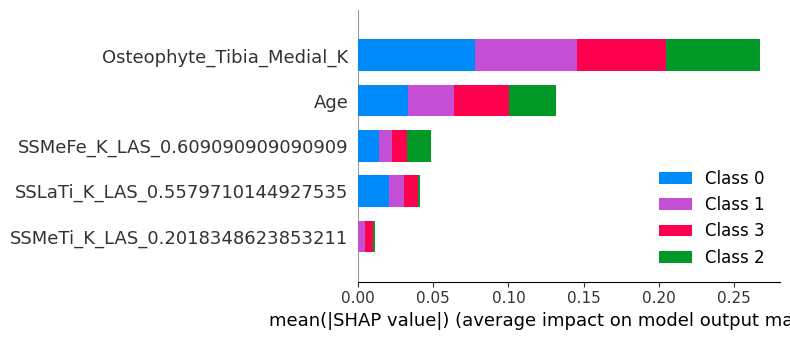

(                  Classifier  Accuracy  F1 Score Macro  \
0  Artificial Neural Network  0.422222        0.283838   

                      Best Params  
0  {'hidden_layer_sizes': (100,)}  , [Index(['SSMeFe_K_LAS_0.609090909090909', 'Osteophyte_Tibia_Medial_K',
       'SSMeTi_K_LAS_0.2018348623853211', 'SSLaTi_K_LAS_0.5579710144927535',
       'Age'],
      dtype='object')])


In [70]:
results = annModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)
print(results)

In [71]:
def decisionTreeModel(X_train, X_test, y_train, y_test):
    dt_clf = DecisionTreeClassifier(max_depth=10)  # You can adjust max_depth as needed
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    dt_param_grid = {'max_depth': [None, 10, 20, 30, 40, 50]}
    dt_search = HalvingGridSearchCV(dt_clf, dt_param_grid, cv=inner_cv)
    dt_search.fit(X_train, y_train)
    dt_pred = dt_search.predict(X_test)
    dt_accuracy = accuracy_score(y_test, dt_pred)
    dt_f1_macro = f1_score(y_test, dt_pred, average='macro')

    selected_features_list = []

    # Permutation importance for feature selection
    perm_importance = permutation_importance(dt_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
    feature_importances = perm_importance.importances_mean
    num_features_to_select = 5
    important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
    selected_features = X_train.columns[important_feature_indices]
    selected_features_list.append(selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    clf_selected = dt_search.best_estimator_
    clf_selected.fit(X_train_selected, y_train)

    results_df = pd.DataFrame({
        'Classifier': "Decision Tree",
        'Accuracy': dt_accuracy,
        'F1 Score Macro': dt_f1_macro,
        'Best Params': [dt_search.best_params_]
    })

    explainer_dt = shap.TreeExplainer(clf_selected)
    shap_values_dt = explainer_dt.shap_values(X_test_selected)
    shap.summary_plot(shap_values_dt[0], X_test_selected, feature_names=X_test_selected.columns)

    return results_df, selected_features_list

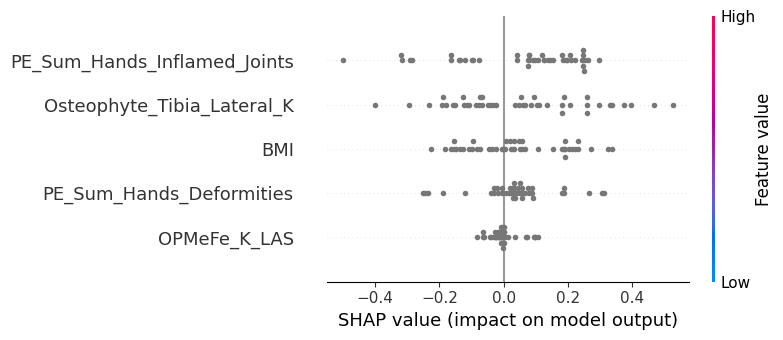

(      Classifier  Accuracy  F1 Score Macro          Best Params
0  Decision Tree  0.266667        0.147469  {'max_depth': None}, [Index(['PE_Sum_Hands_Deformities', 'Osteophyte_Tibia_Lateral_K',
       'OPMeFe_K_LAS', 'BMI', 'PE_Sum_Hands_Inflamed_Joints'],
      dtype='object')])


In [72]:
results = decisionTreeModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)
print(results)